In [6]:
import math, random, os, sys
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [8]:
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # flatten 28x28 → 784
    transforms.Lambda(lambda v: (v - v.mean()) / (v.std() + 1e-8))
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)

def sample_digit(digit, device="cpu"):
    
    idxs = [i for i, (_, y) in enumerate(mnist) if y == digit]
    i = random.choice(idxs)     
    v, y = mnist[i]
    return v.view(-1).to(device)
     

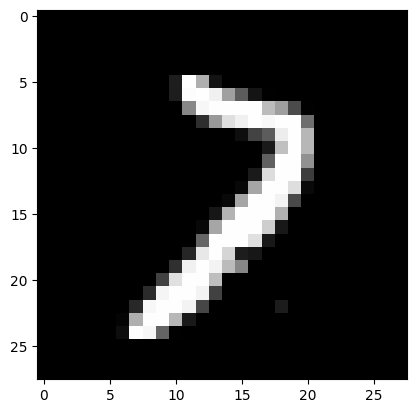

In [9]:
plt.imshow(sample_digit(7).view(28,28), cmap="gray")
plt.show()

In [10]:
# Constants
kBT = 1.0
mu = 1.0
J2 = 10.0
J4 = 10.0

# Chosen through trial and error
bias_scale = 20.0

Nv = 28*28  # number of visible units
Nh = 512     # number of hidden units

J_vh = torch.zeros(Nv, Nh, device=device)   # visible-to-hidden couplings
J_hh = torch.zeros(Nh, Nh, device=device)   # hidden-to-hidden couplings
b_h  = torch.zeros(Nh, device=device)       # hidden biases
# no visible-to-visible couplings

def energy_and_grad(x_v, x_h, b_v, b_h, J_vh, J_hh):
  
    b_v = b_v.to(x_v.device)
    b_h = b_h.to(x_h.device)
    
    # Computer V_theta(x) and its gradients (autograd)
    x_v = x_v.clone().detach().requires_grad_(True)
    x_h = x_h.clone().detach().requires_grad_(True)
    
    # Energy terms
    V = J2*(x_v.pow(2).sum() + x_h.pow(2).sum()) \
      + J4*(x_v.pow(4).sum() + x_h.pow(4).sum()) 
    V = V + (b_v @ x_v) + (b_h @ x_h) 
    V = V + (x_v @ J_vh @ x_h) + 0.5*(x_h @ J_hh @ x_h)
    
    V.backward()

    g_v = x_v.grad.detach()
    g_h = x_h.grad.detach()

    return V.item(), g_v, g_h

In [11]:
def euler_maruyama_step(x_v, x_h, b_v, b_h, J_vh, J_hh, dt, kBT=1.0, mu=1.0):
    
    # Compute energy and gradients
    V, g_v, g_h = energy_and_grad(x_v, x_h, b_v, b_h, J_vh, J_hh)
    
    # Gaussian noise
    noise_v = torch.randn_like(x_v)
    noise_h = torch.randn_like(x_h)
    
    sigma = torch.sqrt(torch.tensor(2.0 * mu * kBT * dt, device=x_v.device, dtype=x_v.dtype))

    # Euler-Maruyama update
    x_vn = x_v - mu * g_v * dt + sigma * noise_v
    x_hn = x_h - mu * g_h * dt + sigma * noise_h
    
    return  x_vn, x_hn, V
    

In [12]:
# Projection (Random Projection) 
# TODO: try alternatives
U = torch.randn(Nh, Nv, device=device) / math.sqrt(Nv)

def fade_schedule(k: int, K: int) -> float:
    """Linear fade from 1 → 0 over K steps."""
    return 1.0 - (k / K)

def visible_bias_schedule(P: torch.Tensor, k: int, K: int, scale=1.0) -> torch.Tensor:
    return (scale * fade_schedule(k, K) * P).to(P.device)

def hidden_bias_schedule(P: torch.Tensor, k: int, K: int, scale=1.0) -> torch.Tensor:
    return (scale * fade_schedule(k, K) * (U @ P)).to(P.device)

In [13]:
# Forward noising trajectory

def run_noising_trajectory(P, tf=2.5, dt=1e-3, snapshots=12, t_eq=0.5, use_trainable=False):
    
    K = int(tf / dt)
    snap_every = max(1, K // snapshots)
    
    if use_trainable:
        Jvh, Jhh = J_vh, J_hh   # trainable parameters
    else:
        Jvh = torch.zeros_like(J_vh)
        Jhh = torch.zeros_like(J_hh)
    
    x_v = torch.randn(Nv, device=device)
    x_h = torch.randn(Nh, device=device)


    states_all = []
    vis_snaps = []
    
    # Bias is scaled (why?)

    # Reach equilibrium
    K_eq = int(t_eq / dt)
    for _ in range(K_eq):
        b_v = (P * bias_scale).to(P.device)
        b_h = ((U @ P) * bias_scale).to(P.device)    
        x_v, x_h, V = euler_maruyama_step(x_v, x_h, b_v, b_h, Jvh, Jhh, dt, kBT, mu)

    states_all.append((x_v.clone(), x_h.clone()))
    for k in range(K):
        b_v = visible_bias_schedule(P, k, K, scale=bias_scale)
        b_h = hidden_bias_schedule(P, k, K, scale=bias_scale)

        x_v, x_h, V = euler_maruyama_step(x_v, x_h, b_v, b_h, Jvh, Jhh, dt, kBT, mu)

        states_all.append((x_v.clone(), x_h.clone()))
        
        if k % snap_every == 0 or k == K - 1:
            vis_snaps.append(x_v.clone())

        #if k % (K // 10) == 0:
           #print(f"Step {k}/{K}, V={V:.2f}")

    return states_all, vis_snaps
    

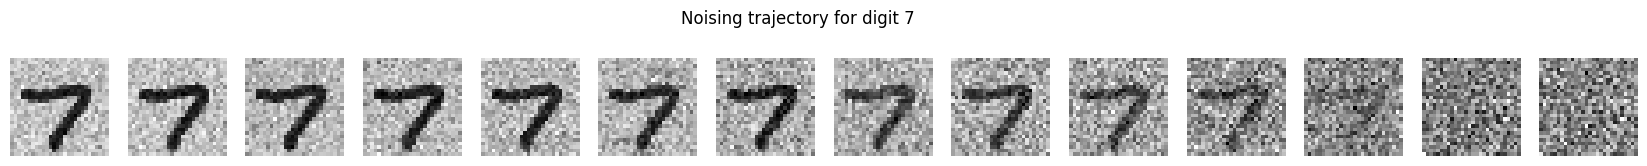

In [14]:
digit_id = 7
P = sample_digit(digit_id)

_, snaps = run_noising_trajectory(P, tf=2.5, dt=1e-3, snapshots=12)


plt.figure(figsize=(1.5*len(snaps), 2))
for i, state in enumerate(snaps):
    ax = plt.subplot(1, len(snaps), i+1)
    ax.imshow(state.view(28, 28).detach().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.suptitle(f"Noising trajectory for digit {digit_id}")
plt.show()

In [15]:
# --- NEW: differentiable gradient of V_θ(x) and reverse-step NLL ---

def grad_V_param(x_v, x_h, b_v, b_h, J_vh, J_hh, J2, J4):
    """
    Fully differentiable ∂V/∂x evaluated at (x_v, x_h).
    IMPORTANT: uses only tensor ops; no autograd backward() inside.
    """
    # visible gradient
    g_v = 2*J2*x_v + 4*J4*(x_v**3) + b_v + (J_vh @ x_h)
    # hidden gradient (J_hh used in energy as 0.5*x_h^T J_hh x_h -> gradient is J_hh @ x_h for symmetric J_hh)
    g_h = 2*J2*x_h + 4*J4*(x_h**3) + b_h + (J_vh.T @ x_v) + (J_hh @ x_h)
    return g_v, g_h

def reverse_step_nll_autograd(
    x_v, x_h, x_v_next, x_h_next,
    J_vh, J_hh, b_h,
    dt, mu=1.0, kBT=1.0, J2=10.0, J4=10.0
):
    """
    Reverse-step (discrete OM) NLL at x' given (x -> x').
    Returns a scalar Tensor with a valid autograd graph w.r.t. (J_vh, J_hh, b_h).
    """
    # reverse model has no visible bias
    b_v0 = torch.zeros_like(x_v_next)

    # ∂V at x'
    g_vn, g_hn = grad_V_param(x_v_next, x_h_next, b_v0, b_h, J_vh, J_hh, J2, J4)

    dx_v = x_v_next - x_v
    dx_h = x_h_next - x_h

    r_v = -dx_v + mu * g_vn * dt
    r_h = -dx_h + mu * g_hn * dt

    denom = (4.0 * mu * kBT * dt)
    nll = (r_v.pow(2).sum() + r_h.pow(2).sum()) / denom  # Tensor (scalar)

    return nll


In [36]:
# --- NEW: fresh parameters for the autograd+Adam path ---
# (kept separate so you don't clobber your old experiment variables)

J_vh = nn.Parameter(torch.randn(Nv, Nh, device=device) * 0.01 / math.sqrt(Nv + Nh))
J_hh = nn.Parameter(torch.randn(Nh, Nh, device=device) * 0.01 / math.sqrt(Nh))
with torch.no_grad():
    J_hh.copy_(0.5 * (J_hh + J_hh.T))  # ensure symmetric at init
b_h  = nn.Parameter(torch.zeros(Nh, device=device))

optimizer = torch.optim.Adam([J_vh, J_hh, b_h], lr=1e-3, betas=(0.9, 0.99))


In [31]:
# --- NEW: held-out validation NLL on a fixed trajectory ---
torch.manual_seed(1234)
P_val = sample_digit(1, device=device)

def eval_reverse_nll(P, J_vh, J_hh, b_h, dt_forward=1e-4, dt_obj=5e-4, tf=0.2):
    states_all, _ = run_noising_trajectory(P, tf=tf, dt=dt_forward, use_trainable=False)
    num_steps = len(states_all) - 1
    if num_steps <= 0:
        return float('nan')

    total = 0.0
    for (xv, xh), (xv2, xh2) in zip(states_all[:-1], states_all[1:]):
        nll = reverse_step_nll_autograd(xv, xh, xv2, xh2, J_vh, J_hh, b_h,
                                        dt=dt_obj, mu=mu, kBT=kBT, J2=J2, J4=J4)
        total += nll.item()
    return total / num_steps


In [32]:
# --- NEW: autograd + Adam training loop ---
def train_model_autograd_adam(
    P,                      # fixed pattern (or pass None and sample inside)
    num_epochs=2,
    num_digits=1,
    dt_forward=1e-4,        # stable forward SDE
    dt_obj=5e-4,            # slightly larger for stronger signal in reverse objective
    tf_forward=0.5,
    lr=1e-3,
    clip_grad=1.0,
    do_resample_digit=False # set True to resample P each "digit"
):
    global J_vh, J_hh, b_h, optimizer

    # (re)create optimizer in case lr changed
    optimizer = torch.optim.Adam([J_vh, J_hh, b_h], lr=lr, betas=(0.9, 0.99))

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")

        for d in range(num_digits):
            P_use = sample_digit(0, device=device) if (do_resample_digit or P is None) else P

            # forward (noising) trajectory does NOT depend on trainable params
            states_all, _ = run_noising_trajectory(
                P_use, tf=tf_forward, dt=dt_forward, use_trainable=False
            )

            num_steps = len(states_all) - 1
            if num_steps <= 0:
                continue

            # average loss over steps
            total_loss = 0.0
            for step, ((x_v, x_h), (x_vn, x_hn)) in enumerate(zip(states_all[:-1], states_all[1:])):
                nll = reverse_step_nll_autograd(
                    x_v, x_h, x_vn, x_hn,
                    J_vh, J_hh, b_h,
                    dt=dt_obj, mu=mu, kBT=kBT, J2=J2, J4=J4
                )
                total_loss = total_loss + nll / num_steps

                if num_steps >= 5 and step % (num_steps // 5) == 0:
                    print(f"  Digit {d+1}/{num_digits}, Step {step}/{num_steps}, NLL={nll.item():.2f}")

            # one Adam step
            optimizer.zero_grad()
            total_loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_([J_vh, J_hh, b_h], max_norm=clip_grad)
            optimizer.step()

            # keep J_hh symmetric
            with torch.no_grad():
                J_hh.copy_(0.5 * (J_hh + J_hh.T))

            # logging
            print("||J_vh||:", J_vh.norm().item(),
                  "||J_hh||:", J_hh.norm().item(),
                  "||b_h||:",  b_h.norm().item())

            epoch_loss += total_loss.item()

        # average over digits
        epoch_loss /= max(1, num_digits)
        losses.append(epoch_loss)

        normalized_loss = epoch_loss / (Nv + Nh)
        val_nll = eval_reverse_nll(P_val, J_vh, J_hh, b_h, dt_forward=dt_forward, dt_obj=dt_obj, tf=0.2)
        print(f"Epoch {epoch+1} complete | Train Avg NLL={epoch_loss:.2f} (norm {normalized_loss:.4f}) | "
              f"Val NLL={val_nll:.2f}")

    return J_vh, J_hh, b_h, losses


In [ ]:
# Choose a fixed training pattern (keeps logs less noisy)
torch.manual_seed(42)
P_train = sample_digit(0, device=device)

J_vh, J_hh, b_h, losses = train_model_autograd_adam(
    P=P_train,
    num_epochs=100,
    num_digits=1,
    dt_forward=1e-4,
    dt_obj=5e-4,    # a little larger than forward dt helps identifiability
    tf_forward=2.5,
    lr=1e-2,
    clip_grad=1.0,
    do_resample_digit=False
)



=== Epoch 1/100 ===
  Digit 1/1, Step 0/25000, NLL=202.36
  Digit 1/1, Step 5000/25000, NLL=173.62
  Digit 1/1, Step 10000/25000, NLL=173.63
  Digit 1/1, Step 15000/25000, NLL=143.10
  Digit 1/1, Step 20000/25000, NLL=140.80
||J_vh||: 0.6573531627655029 ||J_hh||: 0.5325369834899902 ||b_h||: 0.022626442834734917
Epoch 1 complete | Train Avg NLL=154.88 (norm 0.1195) | Val NLL=161.41

=== Epoch 2/100 ===
  Digit 1/1, Step 0/25000, NLL=200.64
  Digit 1/1, Step 5000/25000, NLL=181.17
  Digit 1/1, Step 10000/25000, NLL=163.19
  Digit 1/1, Step 15000/25000, NLL=147.09
  Digit 1/1, Step 20000/25000, NLL=140.62
||J_vh||: 1.2402215003967285 ||J_hh||: 0.9837079644203186 ||b_h||: 0.04397988319396973
Epoch 2 complete | Train Avg NLL=154.36 (norm 0.1191) | Val NLL=160.99

=== Epoch 3/100 ===
  Digit 1/1, Step 0/25000, NLL=188.17
  Digit 1/1, Step 5000/25000, NLL=167.60
  Digit 1/1, Step 10000/25000, NLL=154.58
  Digit 1/1, Step 15000/25000, NLL=143.28
  Digit 1/1, Step 20000/25000, NLL=134.18


KeyboardInterrupt: 

In [26]:
def run_generation(J_vh, J_hh, b_h, tf=2.5, dt=1e-3, snapshots=12):
    
    K = int(tf / dt)
    snap_every = max(1, K // snapshots)

    x_v = torch.randn(Nv)
    x_h = torch.randn(Nh)

    vis_states = []

    for k in range(K):
        b_v = torch.zeros(Nv)  

        x_v, x_h, V = euler_maruyama_step(
            x_v, x_h, b_v, b_h, J_vh, J_hh, dt, kBT, mu
        )

        if k % snap_every == 0 or k == K - 1:
            vis_states.append(x_v.clone())

    return vis_states

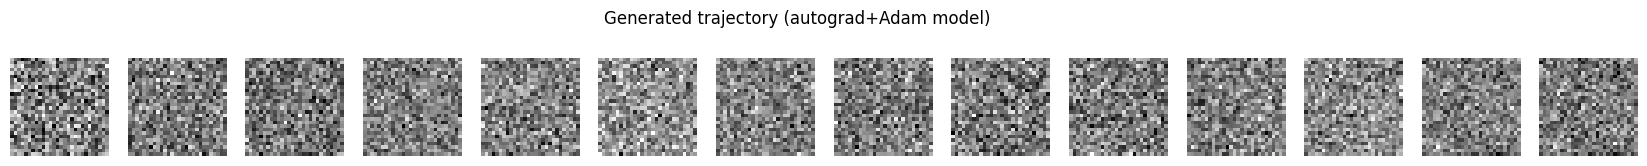

In [27]:
samples = run_generation(J_vh, J_hh, b_h, tf=2.5, dt=1e-3, snapshots=12)

plt.figure(figsize=(1.5*len(samples), 2))
for i, state in enumerate(samples):
    ax = plt.subplot(1, len(samples), i+1)
    ax.imshow(state.view(28, 28).detach().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated trajectory (autograd+Adam model)")
plt.show()